### Load Bostong housing price data

In [21]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [22]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


### Normalize Features

In [23]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### Build Network

In [48]:
from keras import models, layers

def build_model():   
    model = models.Sequential()

    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    
    return model

### Prepare validation

In [53]:
import numpy as np

k=4
num_val_samples = len(train_data)//k

In [60]:
num_epochs = 500
all_mae_histories=[]

for i in range(k):
    print(f'processing fold {i}')
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=1,
                        verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


In [65]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plot validation scores

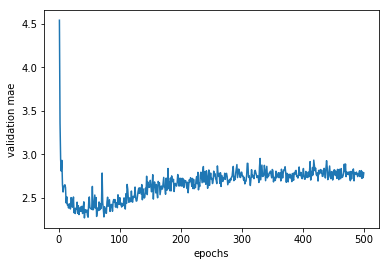

In [68]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

### Replot with smooth vae and removing first 10

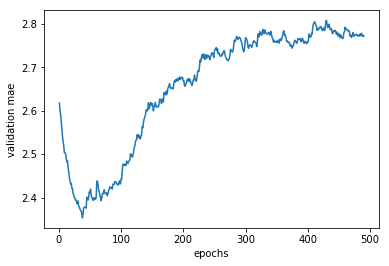

In [72]:
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

### Train final model

In [76]:
model = build_model()
model.fit(train_data,
          train_targets,
          epochs=80,
          batch_size=16,
          verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 1ms/step


2.696495168349322